# Active Learning With Burger's Classifier & Data Set
### For research paper: Active Learning To Reduce Human Labeling For Automatic Psychological TextClassification
### Author: Jahson O'Dwyer Wha Binda

# Burger's Codebase

Preprocessing, and classifier setup taken from Burgers research paper.

In [1]:
#set seed
seed = 57839
import os
os.environ['PYTHONHASHSEED']=str(seed)
import sys

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

import csv
import pandas as pd
import scipy
import scipy.stats as stats
import functools
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import sklearn
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn import metrics, preprocessing, svm
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf

import tensorflow as tf
tf.random.set_seed(seed)

from tensorflow.python.keras.metrics import Metric
from tensorflow import keras
# import talos
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Dense, Flatten, Embedding, SimpleRNN, LSTM, GRU, Bidirectional,Dropout

from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Import

In [2]:
# read in datasets (already pre-processed)
def readcsv(fname,istext):
    if istext:
        with open(fname,'rt') as f:
            reader=csv.reader(f)
            next(reader)
            data = []
            for row in reader:
                for item in row:
                    data.append(item)
            f.close()
    else:
        with open(fname,'r') as f:
            reader=csv.reader(f,delimiter=';')
            next(reader)
            data = list(reader)
            data = np.asarray(data, dtype='int')
            f.close()
    return data 

# read in training, validation, and test set utterances
train_text = readcsv('Data/DatasetsForH1/H1_train_texts.csv',True)
val_text = readcsv('Data/DatasetsForH1/H1_validate_texts.csv', True)
test_text = readcsv('Data/DatasetsForH1/H1_test_texts.csv',True)

# read in training, validation, and test set labels
train_labels = readcsv('Data/DatasetsForH1/H1_train_labels.csv',False)[:,0:9]
val_labels = readcsv('Data/DatasetsForH1/H1_validate_labels.csv', False)[:,0:9]
test_labels = readcsv('Data/DatasetsForH1/H1_test_labels.csv',False)[:,0:9]

print(np.unique(train_labels))

train_labels = np.where(train_labels == 1, 0, train_labels)
train_labels = np.where(train_labels > 1, 1, train_labels)
test_labels = np.where(test_labels == 1, 0, test_labels)
test_labels = np.where(test_labels > 1, 1, test_labels)


print(train_text[0:5])

[0 1 2 3]
['lot people may think well lot people might not like me', 'might not working fast enough their standards', 'may not able graduate', 'would get bad performance review', 'friends will get annoyed by me']


In [3]:
#for later use
schemas = ["Attach","Comp","Global","Health","Control","MetaCog","Others","Hopeless","OthViews"]

In [4]:
# prepare tokenizer
max_words = 2000
t = Tokenizer(num_words = max_words)
t.fit_on_texts(train_text)
vocab_size = len(t.word_index) + 1
print(vocab_size)

2624


In [5]:
# integer encode all utterances
encoded_train = t.texts_to_sequences(train_text)
encoded_validate = t.texts_to_sequences(val_text)
encoded_test = t.texts_to_sequences(test_text)

# pad documents to a max length of 25 words
max_length = 25

padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_validate = pad_sequences(encoded_validate, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

print(encoded_train[0:5])

[[147, 28, 48, 37, 101, 147, 28, 32, 1, 8, 5], [32, 1, 155, 658, 14, 125, 568], [48, 1, 19, 448], [2, 11, 53, 449, 659], [50, 6, 11, 373, 98, 5]]


In [6]:
%%time
# wall time to run: ~ 10sec
# load all embeddings into memory
embeddings_index = dict()
f = open('Data/glove.6B/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.
Wall time: 13.7 s


In [7]:
vec_dims = 100
embedding_matrix = np.zeros((vocab_size, vec_dims))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [8]:
# create tfidf weighted encoding matrix of utterances
train_sequences = t.texts_to_matrix(train_text,mode='tfidf')
val_sequences =  t.texts_to_matrix(val_text,mode='tfidf')
test_sequences = t.texts_to_matrix(test_text,mode='tfidf')
print(train_sequences[0:5])
print(train_sequences.shape)

[[0.         1.29214445 0.         ... 0.         0.         0.        ]
 [0.         1.29214445 0.         ... 0.         0.         0.        ]
 [0.         1.29214445 0.         ... 0.         0.         0.        ]
 [0.         0.         1.69021763 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(4151, 2000)


In [9]:
# we want to normalize the word vectors
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [10]:
# create utterance embeddings as tfidf weighted average of normalized word vectors
def seq2vec(datarow,embedmat):
  #initialize an empty utterance vector of the same length as word2vec vectors
  seqvec = np.zeros((100,))
  #counter for number of words in a specific utterance
  wordcount = 1
  #we iterate over the 2000 possible words in a given utterance
  wordind = 1
  while (wordind < len(datarow)):
    #the tf-idf weight is saved in the cells of datarow
    tfidfweight = datarow[wordind]
    if not tfidfweight is None:
      wordembed = tfidfweight * embedmat[wordind,]
      seqvec = seqvec + normalize(wordembed)
      wordcount = wordcount + 1
    wordind = wordind + 1
  return seqvec/wordcount

In [11]:
# go through the matrix and embed each utterances
def embed_utts(sequences,embedmat):
  vecseq = [seq2vec(seq,embedmat)for seq in sequences]
  return vecseq

In [12]:
%%time
# wall time to run: ~ 1min 14s
# embedd all three datasets
train_embedutts = embed_utts(train_sequences,embedding_matrix)
val_embedutts = embed_utts(val_sequences,embedding_matrix)
test_embedutts = embed_utts(test_sequences,embedding_matrix)

Wall time: 1min 52s


# SVM

In [13]:
#SVM/SVR
def svm_scaler(train_X):
        #scale the data
        scaler_texts = StandardScaler()
        scaler_texts = scaler_texts.fit(train_X)
        return scaler_texts

scaler_texts = svm_scaler(train_embedutts)

## Modified

svm_custom function modfied to return a single MultiOutput Classifier for all schema rather than an array of classifiers for each individual schema

In [14]:
from sklearn.multioutput import MultiOutputClassifier

def svm_custom(train_X,train_y,text_scaler,kern,classification):
        models=[]
        train_X = text_scaler.transform(train_X)
        
        model = MultiOutputClassifier(svm.SVC(kernel=kern, probability=True), n_jobs=-1)
#         model = MultiOutputClassifier(svm.SVR(kernel=kern), n_jobs=-1)
        
        return model, train_X
        
#         #fit a new support vector regression for each schema
#         for schema in range(9):
#             if classification:
#                 model = svm.SVC(kernel=kern)
#             else:
#                 model = svm.SVR(kernel=kern)
#             model.fit(train_X, train_y[:,schema])
#             models.append(model)
#         return models

In [15]:
#### Goodness of Fit
def gof_spear(X,Y):
    #spearman correlation of columns (schemas)
    gof_spear = np.zeros(X.shape[1])    
    for schema in range(9):
        rho,p = scipy.stats.spearmanr(X[:,schema],Y[:,schema])
        gof_spear[schema]=rho
    return gof_spear

In [16]:
# weighting model output (spearman correlations) by schema frequencies in training set and returning mean over schemas
def performance(train_y,output):
    train_y = np.array(train_y)
    train_y[train_y>0]=1
    weighting = train_y.sum(axis=0)/train_y.shape[0]
    perf = output * weighting
    return np.nanmean(np.array(perf), axis=0)

In [17]:
def svm_predict(svm_models,test_X,train_y,test_y,text_scaler):
    #empty array to collect the results (should have shape of samples to classify)
    votes = np.zeros(test_y.shape)
    for schema in range(9):
        svm_model=svm_models[schema]
        prediction = svm_model.predict(text_scaler.transform(test_X))
        votes[:,schema] = prediction
    out = votes
    gof = gof_spear(out,test_y)
    perf = performance(train_y,gof)
    return out,perf

In [18]:
model, train_embedutts = svm_custom(train_embedutts,train_labels,scaler_texts,'linear',1)

# Active Learning

In [19]:
from sklearn.utils import shuffle
train_embedutts, train_labels = shuffle(train_embedutts, train_labels, random_state=47)

## Creation of Active Learner

Initial set for active learner created, for loop makes sure that intial set has one example for each class for the active learner to initialize

In [26]:
from sklearn.metrics import accuracy_score

from modAL.models import ActiveLearner
from modAL.multilabel import min_confidence

initx = []
inity = []

#Make sure initial set have one of each label example
for i in range(len(schemas)):
    foundHigh = False
    foundLow = False
    for j in range(len(train_labels[:,i])):
        if(foundHigh and foundLow):
            break
        
        y = train_labels[:,i][j]
        if(y == 0 and not foundLow):
            foundLow = True
            initx.append(train_embedutts[j])
            inity.append(train_labels[j])
            train_embedutts, train_labels = np.delete(train_embedutts, j, axis=0), np.delete(train_labels, j, axis=0)
        if(y == 1 and not foundHigh):
            foundHigh = True
            initx.append(train_embedutts[j])
            inity.append(train_labels[j])
            train_embedutts, train_labels = np.delete(train_embedutts, j, axis=0), np.delete(train_labels, j, axis=0)
            

learner = ActiveLearner(
    estimator=model,
    query_strategy=min_confidence,
    X_training=initx, y_training=inity
)


pred = learner.predict(test_embedutts)
unqueried_score = accuracy_score(y_true=test_labels, y_pred=pred)
print("{:.2%}".format(unqueried_score))

x_train = train_embedutts
y_train = train_labels
x_test = test_embedutts
y_test = test_labels

21.21%


In [21]:
import random
from sklearn.utils import check_consistent_length

N_QUERIES = 30
performance_history = [unqueried_score]
schema_history = []
        
# print("checked")
for i in range(9):
    schema_history.append([accuracy_score(y_true=y_test[:,i], y_pred=pred[:,i])])

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy.
for index in range(N_QUERIES):
    query_index, query_instance = learner.query(x_train)
    
    query_index = random.choice(query_index[0])
    # Teach our ActiveLearner model the record it has requested.
    X, y = x_train[query_index].reshape(1, -1), y_train[query_index].reshape(1, -1)
    learner.teach(X=X, y=y)
    
    # Remove the queried instance from the unlabeled pool.
    x_train, y_train = np.delete(x_train, query_index, axis=0), np.delete(y_train, query_index, axis=0)
    
    # Calculate and report our model's accuracy.
    qPred = learner.predict(x_test)
    model_accuracy = accuracy_score(y_true=y_test, y_pred=qPred)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
    for i in range(9):
        schema_history[i].append(accuracy_score(y_true=y_test[:,i], y_pred=qPred[:,i]))

Accuracy after query 1: 0.2121
Accuracy after query 2: 0.2121
Accuracy after query 3: 0.2121
Accuracy after query 4: 0.2121
Accuracy after query 5: 0.2121
Accuracy after query 6: 0.2121
Accuracy after query 7: 0.2121
Accuracy after query 8: 0.2121
Accuracy after query 9: 0.2121
Accuracy after query 10: 0.2121
Accuracy after query 11: 0.2121
Accuracy after query 12: 0.2121
Accuracy after query 13: 0.2121
Accuracy after query 14: 0.2121
Accuracy after query 15: 0.2121
Accuracy after query 16: 0.2121
Accuracy after query 17: 0.2121
Accuracy after query 18: 0.2121
Accuracy after query 19: 0.2121
Accuracy after query 20: 0.2121
Accuracy after query 21: 0.2121
Accuracy after query 22: 0.2121
Accuracy after query 23: 0.2121
Accuracy after query 24: 0.2121
Accuracy after query 25: 0.2121
Accuracy after query 26: 0.2121
Accuracy after query 27: 0.2121
Accuracy after query 28: 0.2121
Accuracy after query 29: 0.2121
Accuracy after query 30: 0.2121


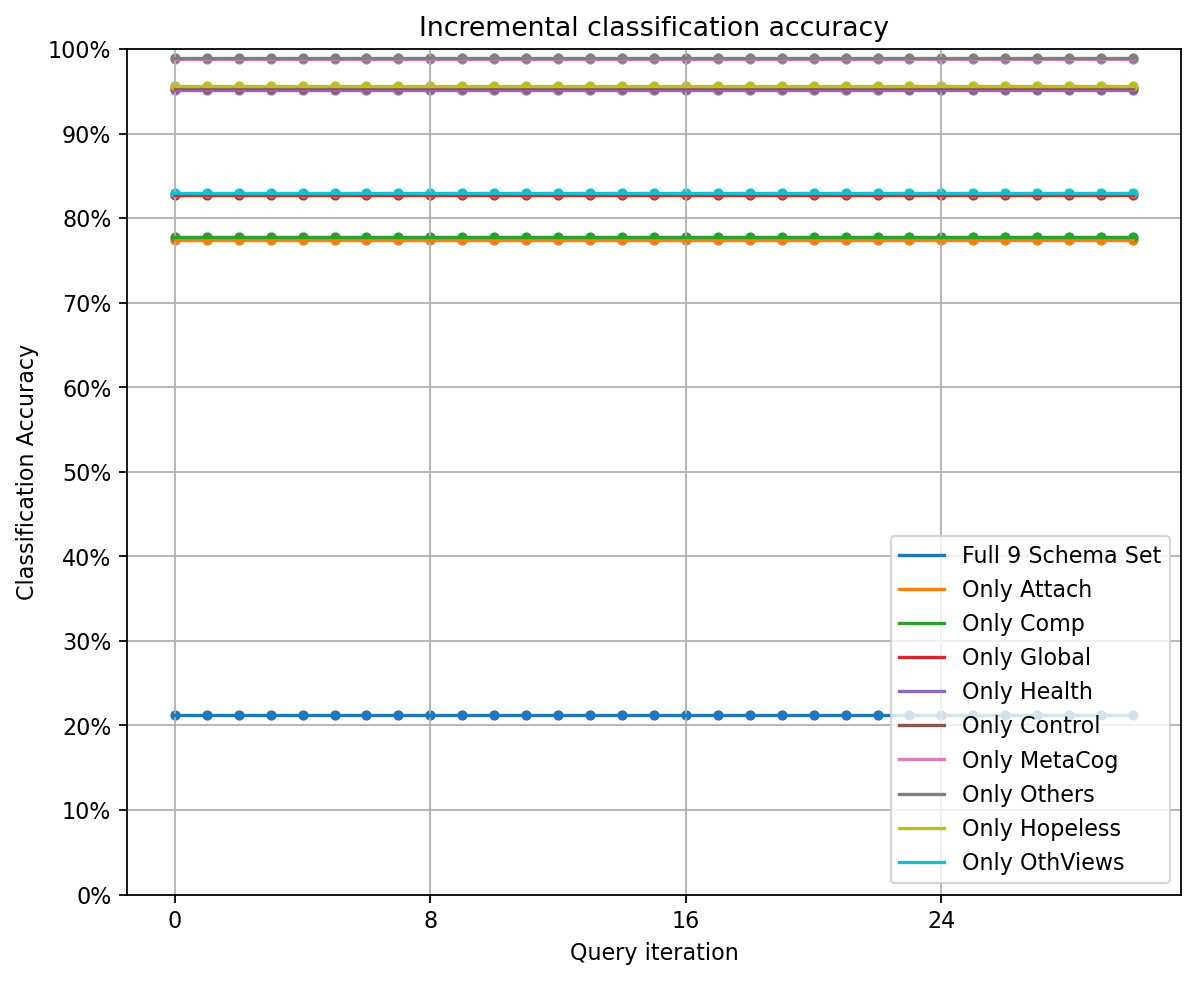

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 7), dpi=160)

ax.plot(performance_history, label="Full 9 Schema Set")
ax.scatter(range(len(performance_history)), performance_history, s=13)
for i in range(9):
    ax.plot(schema_history[i], label="Only "+ schemas[i])
    ax.scatter(range(len(schema_history[i])), schema_history[i], s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.legend(loc="lower right")
plt.show()

(863, 9)
(863, 9)


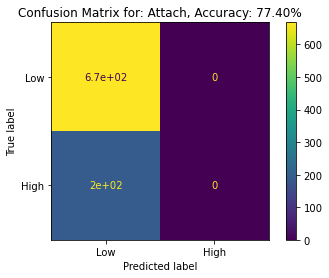

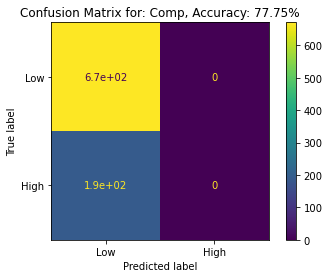

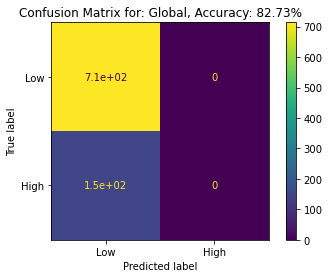

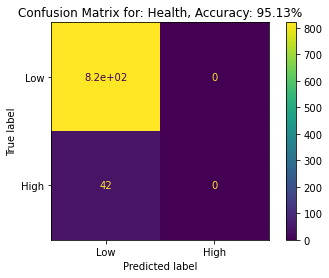

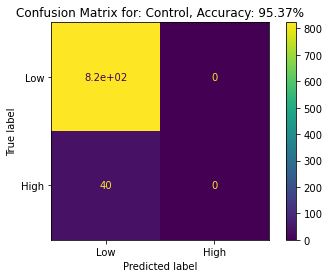

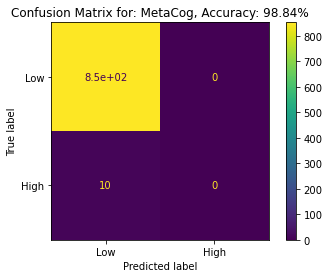

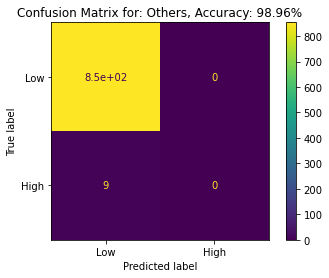

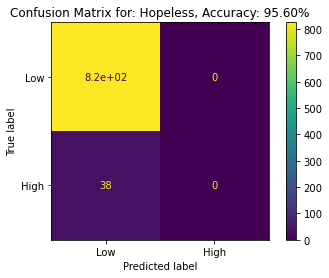

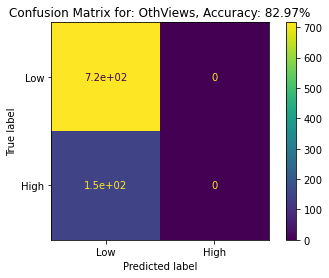

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


preds= learner.predict(x_test)
print(np.shape(preds))
print(np.shape(test_labels))

for i in range(len(schemas)):
    mat = confusion_matrix(y_true=y_test[:,i], y_pred=preds[:,i])
    disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=["Low", "High"]).plot()
    plt.title('Confusion Matrix for: ' + schemas[i] + ", Accuracy: " + "{:.2%}".format(accuracy_score(y_true=y_test[:,i], y_pred=preds[:,i])))
    plt.show()

# gof= gof_spear(preds,test_labels)